In [1]:
# Include libraries which may use in implementation
import numpy as np
import pickle
import random
import sklearn.datasets as ds
from sklearn.utils import shuffle
from keras.utils import np_utils
import matplotlib.pyplot as plt
import os
import glob
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patheffects as PathEffects
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import scipy.io
import scipy.signal
import tensorflow as tf

from tqdm import notebook

Using TensorFlow backend.


# Pooling Layer

In [2]:
class PoolingLayer:
    def __init__(self, mode='max', FSize = 2, stride = 2):
        self.mode = 'max'
        self.FSize = FSize
        self.stride = stride
        self.InShape = 0
        self.outShape = 0
        return
    
    
    def findMax(self, window):
        return np.max(np.max(window.T, axis = len(window.shape)-1), axis = len(window.shape)-2)
    
    
    def PoolForward(self, feature_map, mode='max', FSize = 2, stride = 2 ):
        
        rows , cols, channels  = feature_map.shape
        self.InShape = feature_map.shape
        
        Nh = ((rows - FSize)//stride) + 1
        Nw = ((cols - FSize)//stride) + 1
        Nc = channels
        outStack = np.zeros((Nh,Nw,Nc))
        self.mask = np.zeros(self.InShape)
        
        #Convolving the Filters
        i = 0
        for x in range(0 , (rows - FSize+1 ), stride):
            j = 0
            for y in range(0, (cols - FSize+1 ), stride):
                # Convolving mask on the portion of the image
                outStack[i][j] = self.findMax(feature_map[x : x + FSize , y : y + FSize])
                maxInds = np.where(feature_map[x : x + FSize , y : y + FSize] == outStack[i][j])
                maxInds = tuple([maxInds[0] + x, maxInds[1] + y, maxInds[2]])
                self.mask[maxInds] = 1
                j+=1

            if(j<Nw):
                outStack[i][j+1] =  feature_map[x : x + FSize , cols-1]
                self.mask[i,j+1] = 1
            i+=1

        self.outShape = outStack.shape
        return outStack
        
    def forwardProp(self, X):
        return self.PoolForward(X, self.mode, self.FSize ,self.stride)
    
    def backProp(self, err, lr):
        sizeFactor = np.array(self.InShape) / np.array(self.outShape)
        ReshapedErr = err.repeat( round(sizeFactor[0]), axis= 0).repeat(round(sizeFactor[1]), axis= 1)
        if(np.all(ReshapedErr.shape != self.mask.shape)):
            ReshapedErr = np.pad(ReshapedErr, [(0,1), (0,1), (0,0)], mode='edge')
        
        ReshapedErr = ReshapedErr * self.mask
        return ReshapedErr

# Convolutional Layer

In [3]:
class ConvuLayer:
    def __init__(self, filters, FSize=(1,2,2,1) ,stride=1, pad=0):
      
        #FSize is tuple (numberof Kernels, Rows, Cols, Channels)
        
        #filters must be of the form (number of filters x size x size x number of channels)
        # Rows and Cols must be Same and Odd (Implementation is this way)
        if(filters is None):
            filters = np.random.randn(FSize[0],FSize[1],FSize[2],FSize[3])*0.2
        else:
            FSize = filters.shape
        
        self.FSize = FSize
        self.W = filters.astype('float64')
        self.bias = np.random.randn(FSize[0])*0.2
        self.stride = stride
        
        self.pad = pad
        self.InShape = 0
        self.outShape = 0
        
        return
    
    
    def convolve(self, patch, filtr):
        # Taking dot product and summing 2D into 1 value.
        return np.sum(np.sum(patch*filtr.T, axis = len(filtr.shape)-1), axis = len(filtr.shape)-2)
    
    
    def ConvForward(self, img , filters, stride=1, pad=0):
    
        # The cahnnels of the Input and Weights(Kernel/Filter) must be same
        
        self.InShape = img.shape
        
        # Assuming the filters to be Square with odd number of rows and cols
        FSize = filters.shape[1]           # Getting Rows and Cols of Kernel
        num_filters = filters.shape[0]     # Getting Number of Kernels
        rows , cols  = img.shape[:2]
        
        Nh = ((rows - FSize + 2*pad)//stride) + 1
        Nw = ((cols - FSize + 2*pad)//stride) + 1
        Nc = num_filters
        outStack = np.empty((Nh,Nw,Nc))

        #Convolving the Filters
        """
        for x in range(0 , Nh, stride):
            for y in range(0, Nw, stride):
                # Convolving mask on the portion of the image
                outStack[x][y] = self.convolve(img[x : x + FSize , y : y + FSize] , filters)
        """
        # One Filter Produces One channel in the Output
        for f in range(Nc):
            outStack[:,:,f] = scipy.signal.correlate(img, filters[f], mode="valid")[:,:,0] + self.bias[f]
        #"""  
        
        # Saved For BackPropagation 
        self.D_LeakyRelu = self.leaky_relu_derivative(outStack)
        
        outStack = tf.nn.leaky_relu(outStack, alpha=0.1,name='Leaky_ReLU').numpy()
        
        self.outShape = outStack.shape
        return outStack
    
    
    def forwardProp(self, X):
        self.X = X
        return self.ConvForward(X, self.W, self.stride, self.pad)
    
    
    def backProp(self, err, lr):
        
        err = err * self.D_LeakyRelu
        
        #FlipedW = np.flip(self.W, (1,2))
        #FlipedX = np.flip(self.X, (0,1))
                  
        dLdX = np.zeros(self.InShape)
        
        for f in range(err.shape[2]):
            
            #Computing dl/dX
            dLdX += (scipy.signal.convolve( err[:,:,f:f+1], self.W[f], mode="full"))
            
            #Computing dL/dW
            self.W[f] -= lr * scipy.signal.correlate(self.X , err[:,:,f:f+1], mode="valid")
        
        self.bias -= lr * np.sum(np.sum(err, axis=0), axis=0)
                
        return dLdX
   
    def leaky_relu_derivative(self, s):
        #derivative of relu
        d_act = np.ones(s.size)
        d_act[s.flatten() < 0] = 0
        d_act = d_act.reshape(s.shape)
        return d_act # apply derivative of relu on s and return it's value
    

# FC Layer

In [4]:
# A Neural Layer Containing All essential information about a Layer
class NeuralLayer:
    def __init__(self, InSz, OutSz, activation, W = None):
        
        ## Every Column corresponds to all the weights of one neuron
        self.W = np.random.randn(InSz+1, OutSz)*0.1
        
        # Learned Weights are Inputed
        if(W is not None):
            self.W = W
        self.activation = activation
        
        if(self.activation =="sigm"):
            self.AF = self.sigmoid
            self.d_AF = self.sigmoid_derivative
        elif(self.activation == "tanh"):
            self.AF = self.tanh
            self.d_AF = self.tanh_derivative
        elif(self.activation == "relu"):
            self.AF = self.relu
            self.d_AF = self.relu_derivative
        elif(self.activation == "leaky_relu"):
            self.AF = self.leaky_relu
            self.d_AF = self.relu_derivative
        elif(self.activation == "softmax"):
            self.AF = self.softmax
            self.d_AF = self.softmax_derivative
            
        return
    
    def forwardProp(self, X):
        
        self.X = np.append(np.ones((1 , X.shape[len(X.shape)-1])) , X, axis=0)
        # Before Applying Activation
        self.Yin = np.matmul(self.W.T, self.X)
        
        # After Applying Activation
        self.Yp = self.AF(self.Yin)
        
        return self.Yp
    
    def backProp(self, err, lr):
        # Calculating Error for Back Layer
        
        sigma = np.dot(self.W[1:] , (self.d_AF(self.Yin) * err) )
        
        # Updating Weights
        self.W = self.W - (lr* np.dot(self.X, (self.d_AF(self.Yin)*err).T))
        
        return sigma
    
    #################################################
    ###     Activation Functions & Derivatives    ###
    #################################################
    
    def sigmoid(self, s):
        # activation function
        #return 1/(1 + np.exp(-s)) # apply sigmoid function on s and return it's value
        return scipy.special.expit(s)
    
    def sigmoid_derivative(self, s):
        #derivative of sigmoid
        sig = self.sigmoid(s)
        return sig*(1-sig) # apply derivative of sigmoid on s and return it's value 
    
    
    def tanh(self, s):
        # activation function
        return np.tanh(s) # apply tanh function on s and return it's value

    
    def tanh_derivative(self, s):
        #derivative of tanh
        return 1-np.tanh(s)**2 # apply derivative of tanh on s and return it's value
    
    def relu(self, s):
        # activation function
        #actiV = np.clip(s, 0 ,70)
        actiV = np.maximum(s, 0)
        return actiV # apply relu function on s and return it's value

    def relu_derivative(self, s):
        #derivative of relu
        d_act = np.ones_like(s)
        d_act[s<0] = 0
        return d_act # apply derivative of relu on s and return it's value
    
    def leaky_relu(self, s):
        # activation function
        return tf.nn.leaky_relu(s, alpha=0.1,name='Leaky_ReLU').numpy()
    
    def leaky_relu_derivative(self, s):
        #derivative of relu
        d_act = np.ones(s.size)
        d_act[s.flatten() < 0] = 0
        d_act = d_act.reshape(s.shape)
        return d_act # apply derivative of relu on s and return it's value

    def softmax(self, s):
        #print(np.max(s), np.min(s))
        s = np.clip(s,-700, 700)
        return np.exp(s)/np.sum(np.exp(s),axis=0)

    def softmax_derivative(self, s):
        return 1

# Neural Network

In [5]:
# Create a Neural_Network class

class Neural_Network(object):        
    def __init__(self, batchSz = -1):
        
        # Every Index in the list Represents a Layer
        self.ConvuPoolLayers = []
        self.NeuralLayers = []
        self.batchSz = batchSz
        self.errHistory = []
        self.ValErrHistory = []
        
        return
    
    def AddLayer(self, inputSz, OutputSz, activation = "sigm"):
        self.NeuralLayers.append(NeuralLayer(inputSz, OutputSz, activation))
        return
    ##
    def AddConvuLayer(self, filters = None, FSize=2 ,stride=1, pad=0):
        self.ConvuPoolLayers.append(ConvuLayer(filters, FSize,stride, pad))
        return
    
    def AddPoolLayer(self, mode='max', FSize = 2, stride = 2):
        self.ConvuPoolLayers.append(PoolingLayer(mode, FSize, stride))
        return
    
    ##
    def feedforward(self, X):
        nextIn = (X)
        
        for CL in self.ConvuPoolLayers:
            nextIn = CL.forwardProp(nextIn)
        
        nextIn = np.array([nextIn.flatten()]).T
        
        # predict the value of testX
        for L in self.NeuralLayers:
            nextIn = L.forwardProp(nextIn)
        
        return nextIn
    
    def backwardpropagate(self, Y, y_pred, lr):
        # backward propagate through the network
        ## For the Output Layer
        # Because Softmax layers derivative is Jacobian MAtrix which is very large
        # This formula is derived by combining both cross-entropy derivative and softmax derivative
        Y = Y.reshape(y_pred.shape)
        
        if(self.NeuralLayers[len(self.NeuralLayers)-1].activation == "softmax"):
            Back_err = 2*(y_pred - Y)
        else:
            Back_err = ((-1/Y.size)*(np.divide(Y,y_pred)))
        
        for L in reversed(self.NeuralLayers):
            Back_err = L.backProp(Back_err ,lr)
            
        if(len(self.ConvuPoolLayers)>0):    
            Back_err = Back_err.reshape(self.ConvuPoolLayers[len(self.ConvuPoolLayers)-1].outShape)
            for L in reversed(self.ConvuPoolLayers):
                Back_err = L.backProp(Back_err ,lr)
                
        return Back_err
    
    def crossentropy(self, Y, Y_pred):
        # compute error based on crossentropy loss 
        return -(np.mean(Y*np.log(Y_pred + 0.000001)))
        #return -(np.sum(Y*np.log(Y_pred)))/Y.shape[1]
        #return - np.mean(np.multiply(Y, np.log(Y_pred + 0.000001)) + np.multiply((1-Y), np.log(1-Y_pred + 0.000001)))
        #return -np.mean((Y*np.log(Y_pred) + (1-Y)*np.log(1 - Y_pred))) #error
     
    def train(self, trainX, trainY,epochs = 100, learningRate = 0.001, plot_err = True ,validationX = None, validationY = None):
        # feed forward trainX and trainY and recivce predicted value
        
        trainY = trainY.T
        if(self.batchSz == -1 or  self.batchSz > trainX.shape[0]):
            self.batchSz = trainX.shape[0]
        
        for i in notebook.trange(epochs):
            sumErr = 0
            R = np.random.randint(trainX.shape[0] - self.batchSz+1)
            
            with notebook.trange(R, R+self.batchSz , leave=False, desc="Training ", mininterval=0.5 ) as TI:
                for j in TI:
                    #j = np.random.randint(trainX.shape[0])
                    Y_pred = self.feedforward(trainX[j])
                    # backpropagation with trainX, trainY, predicted value and learning rate.
                    self.backwardpropagate(trainY[:,j], Y_pred, learningRate)

                    sumErr += self.crossentropy( (trainY[:,j]).reshape(Y_pred.shape) , Y_pred)
                    #print("Loss : %f" % ((sumErr/(j-R+1))), end='\r')
                    TI.set_postfix(Loss = (sumErr/(j-R+1)))

            self.errHistory.append(sumErr/self.batchSz)

            # if validationX and validationY are not null than show validation accuracy and error of the model.
            if( (validationX is not None) and (validationY is not None) ):
                V_acc , tmp = self.accuracy(validationX, validationY)
                V_err = 1 - V_acc
                self.ValErrHistory.append(V_err)
                print("Epoch: %d, Training Loss: %f, Validation Accuracy: %f, Validation Error: %f" 
                      % (i+1 ,self.errHistory[len(self.errHistory)-1],V_acc ,V_err),end='\n')
            else:
                print("Epoch: %d, Training Loss: %f" % (i+1 ,self.errHistory[len(self.errHistory)-1]),end='\n')

        # plot error of the model if plot_err is true    
        if(plot_err):
            if( (validationX is not None) and (validationY is not None) ):
                plt.plot(np.arange(len(self.ValErrHistory)), self.ValErrHistory, label="Validation Err")
            plt.plot(np.arange(len(self.errHistory)), self.errHistory, label="Training Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Error")
            plt.legend()
            plt.show()
        return

    
    def predict(self, X):
    
        Yp = np.zeros(X.shape[0])
        for i in notebook.trange(X.shape[0], leave=False, desc="Predicting " , mininterval=0.5):
            Yp[i] = np.argmax(self.feedforward(X[i]))
       
        return Yp
    
    def accuracy(self, X, Y):
        # predict the value of trainX
        Yp = self.predict(X)
        
        # compare it with testY
        T = np.argmax(Y, axis=0)
        acc = np.zeros(Yp.shape)
        acc[Yp==T] = 1
        
        acc = sum(acc)/T.size
        
        # compute accuracy, print it and show in the form of picture
        return acc, Yp # return accuracy    
        
    def saveModel(self,name):
        # save your trained model, it is your interpretation how, which and what data you store
        # which you will use later for prediction
        print("Saving Model...")

        pickle.dump(self , open(name, "wb"))

        print("Model Saved in ", name)
        return


    def loadModel(self, name):
        # load your trained model, load exactly how you stored it.
        print("Loading Model...")

        LM = pickle.load(open(name, "rb"))

        self.ConvuPoolLayers = LM.ConvuPoolLayers
        self.NeuralLayers = LM.NeuralLayers
        self.batchSz = LM.batchSz
        self.errHistory = LM.errHistory
        self.ValErrHistory = LM.ValErrHistory

        print("Model Loaded.")
        return LM

# Util Functions

In [6]:
def VisulaizeFilters(filters):
    plt.figure(figsize=(25,15))
    for i in range(filters.shape[0]):
        ax = plt.subplot(6,12,i+1)
        #ax.set_axis_off()
        if(filters.shape[3]==1):
            plt.imshow(filters[i,:,:,0], cmap='gray')
        else:
            plt.imshow(filters[i,:,:])

    #plt.tight_layout()
    plt.show()

In [7]:
#Taken From CV Assignment 4
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    
    title = 'Confusion Matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    
    print('Confusion Matrix')
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# MNIST

In [8]:
# Function to load dataset
def loadDataset(path):
    print('Loading Dataset...')
    train_x, train_y, test_x, test_y = [], [], [], []
    
    for i in range(10):
        for filename in glob.glob(path + '\\train\\' + str(i)+'\\*.png'):
            im=plt.imread(filename)
            train_x.append(im)
            train_y.append(i)
    
    for i in range(10):
        for filename in glob.glob(path + '\\test\\' + str(i)+'\\*.png'):
            im=plt.imread(filename)
            test_x.append(im)
            test_y.append(i)
    
    print('Dataset loaded...')
    
    return np.array(train_x), np.array(train_y), np.array(test_x),np.array(test_y)

In [247]:
train_x, train_y, test_x, test_y = loadDataset("./")

Loading Dataset...
Dataset loaded...


In [248]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [249]:
## Data Processing

mean_train = np.sum(train_x,axis=0)/train_x.shape[0]
mean_test = np.sum(test_x,axis=0)/test_x.shape[0]


test_x = test_x - np.mean(mean_test+mean_train, axis = 0  )
train_x = train_x - np.mean(mean_test+mean_train, axis = 0 )



print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


In [250]:
#One Hot Encoding 
train_y = np_utils.to_categorical(train_y)
test_y = np_utils.to_categorical(test_y)

# Shuffling Data
train_x, train_y = shuffle(train_x , train_y)
test_x, test_y = shuffle(test_x,test_y)

train_x = train_x.reshape(-1,28,28,1)
test_x = test_x.reshape(-1,28,28,1)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 10)
(10000, 10)


In [253]:
# Creating Neural Network
net = Neural_Network(batchSz=1500)
net.AddConvuLayer(None, (12,5,5,1))
net.AddPoolLayer(mode='max')
#net.AddConvuLayer(None, (24,3,3,1))
#net.AddPoolLayer(mode='max')
#net.AddLayer(600 , 256, "sigm")
#net.AddLayer(256, 128, "sigm")
net.AddLayer(1728, 128, "sigm")
net.AddLayer(128, 10, "softmax")

Epoch: 1, Training Loss: 0.077724, Validation Accuracy: 0.869000, Validation Error: 0.131000


Epoch: 2, Training Loss: 0.035723, Validation Accuracy: 0.940000, Validation Error: 0.060000


Epoch: 3, Training Loss: 0.022441, Validation Accuracy: 0.945000, Validation Error: 0.055000


Epoch: 4, Training Loss: 0.022728, Validation Accuracy: 0.951000, Validation Error: 0.049000


Epoch: 5, Training Loss: 0.017851, Validation Accuracy: 0.958000, Validation Error: 0.042000



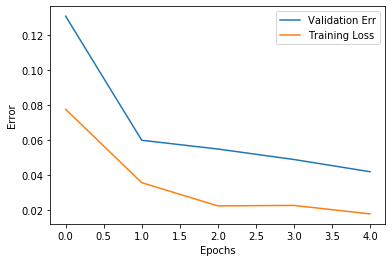

In [255]:
net.train(train_x[:], train_y[:], epochs = 5, learningRate = 0.02, validationX = test_x[:1000], validationY = test_y[:1000].T)

In [256]:
net.saveModel("bestModelMNIST.mdl")

Saving Model...
Model Saved in  bestModelMNIST.mdl


In [257]:
mm = Neural_Network()
mm.loadModel("bestModelMNIST.mdl")
acc, Yp = mm.accuracy(test_x,test_y.T)
print("Accuracy = ", acc)

Loading Model...
Model Loaded.


Accuracy =  0.9545


Confusion Matrix


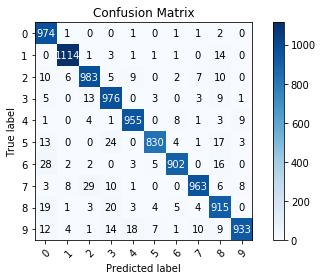

In [258]:
digits = np.argmax(test_y, axis=1)
plot_confusion_matrix(digits,Yp, unique_labels(digits))

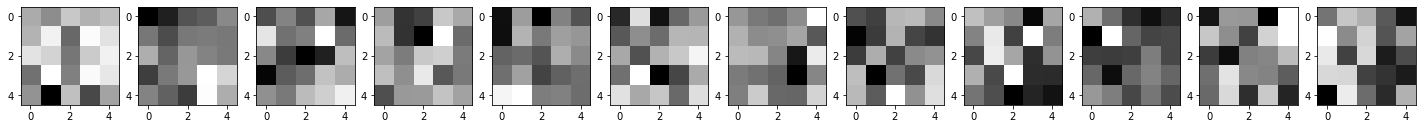

In [254]:
VisulaizeFilters(net.ConvuPoolLayers[0].W)

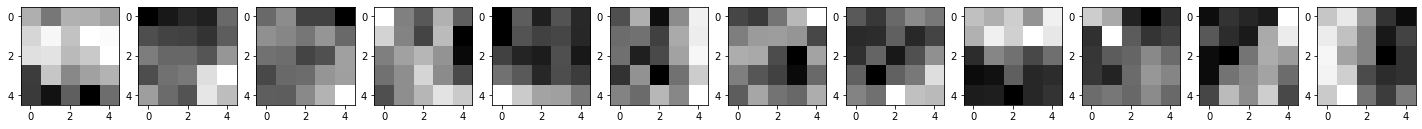

In [259]:
VisulaizeFilters(net.ConvuPoolLayers[0].W)

# CIFAR-10

In [9]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [10]:
def ReadCifar10(path):
    test = unpickle(path + "/test_batch")
    
    train_x = np.empty((0,3072), dtype='uint8')
    train_y = np.empty((0,))
    for i in range(1,6):
        train = unpickle(path + "/data_batch_" + str(i))
        train_x = np.append(train_x, train[b'data'], axis=0)
        train_y = np.append(train_y, np.array(train[b'labels']) , axis=0)
    
    return test[b'data'], np.array(test[b'labels']), train_x, train_y

In [11]:
Ctest_x, Ctest_y, Ctrain_x, Ctrain_y = ReadCifar10("./cifar_10")

print(Ctest_x.shape)
print(Ctest_y.shape)
print(Ctrain_x.shape)
print(Ctrain_y.shape)

(10000, 3072)
(10000,)
(50000, 3072)
(50000,)


In [12]:
## One Hot encoding the Y
Ctest_y = np_utils.to_categorical(Ctest_y)
Ctrain_y = np_utils.to_categorical(Ctrain_y)

## Normalizing the pixel value
Ctest_x = Ctest_x / 255.0
Ctrain_x = Ctrain_x / 255.0 

## Reshaping the X to a valid Image dimensions
Ctest_x = Ctest_x.reshape(-1,3,32,32).transpose((0,2,3,1))
Ctrain_x = Ctrain_x.reshape(-1,3,32,32).transpose((0,2,3,1))

Cvalid_x = Ctest_x[:1000]
Cvalid_y = Ctest_y[:1000]


print(Ctest_x.shape)
print(Ctest_y.shape)
print(Ctrain_x.shape)
print(Ctrain_y.shape)
print(Cvalid_x.shape)
print(Cvalid_y.shape)

(10000, 32, 32, 3)
(10000, 10)
(50000, 32, 32, 3)
(50000, 10)
(1000, 32, 32, 3)
(1000, 10)


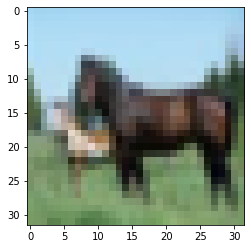

In [13]:
plt.imshow(Ctrain_x[12])

In [14]:
meta = unpickle("./cifar_10/batches.meta")
classes = [meta[b'label_names'][i].decode() for i in range(len(meta[b'label_names']))]
classes = np.array(classes)
classes

array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
       'horse', 'ship', 'truck'], dtype='<U10')

In [25]:
# Creating Neural Network
net1 = Neural_Network(batchSz=10000)

net1.AddConvuLayer(None, (32,5,5,3))
net1.AddPoolLayer(mode='max')
net1.AddConvuLayer(None, (32,5,5,32))
net1.AddConvuLayer(None, (32,5,5,32))
net1.AddPoolLayer(mode='max')
#net1.AddConvuLayer(None, (28,3,3,30))
#net1.AddPoolLayer(mode='max')

net1.AddLayer(288  , 128, "leaky_relu")
net1.AddLayer(128, 64, "leaky_relu")
net1.AddLayer(64, 10, "softmax")

Epoch: 1, Training Loss: 0.110902, Validation Accuracy: 0.581000, Validation Error: 0.419000


Epoch: 2, Training Loss: 0.106560, Validation Accuracy: 0.589000, Validation Error: 0.411000


Epoch: 3, Training Loss: 0.107451, Validation Accuracy: 0.581000, Validation Error: 0.419000


Epoch: 4, Training Loss: 0.109096, Validation Accuracy: 0.591000, Validation Error: 0.409000


Epoch: 5, Training Loss: 0.108239, Validation Accuracy: 0.591000, Validation Error: 0.409000


Epoch: 6, Training Loss: 0.109492, Validation Accuracy: 0.586000, Validation Error: 0.414000


Epoch: 7, Training Loss: 0.108625, Validation Accuracy: 0.595000, Validation Error: 0.405000


Epoch: 8, Training Loss: 0.108501, Validation Accuracy: 0.590000, Validation Error: 0.410000


Epoch: 9, Training Loss: 0.107653, Validation Accuracy: 0.594000, Validation Error: 0.406000


Epoch: 10, Training Loss: 0.109753, Validation Accuracy: 0.595000, Validation Error: 0.405000



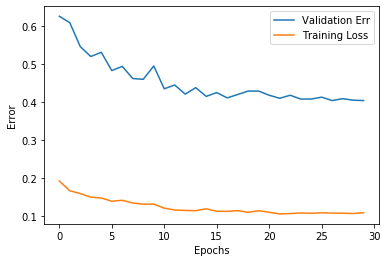

In [32]:
net1.train(Ctrain_x[:], Ctrain_y[:], epochs = 10, learningRate = 0.001, validationX = Cvalid_x[:], validationY = Cvalid_y[:].T)

In [33]:
net1.saveModel("bestModelCIFAR2.mdl")

Saving Model...
Model Saved in  bestModelCIFAR2.mdl


In [15]:
net1 = Neural_Network()
net1.loadModel("bestModelCIFAR2.mdl")

Loading Model...
Model Loaded.


In [34]:
mm1 = Neural_Network()
mm1.loadModel("bestModelCIFAR2.mdl")
acc, Yp = mm1.accuracy(Ctest_x[:],Ctest_y[:].T)
print("Accuracy = ", acc)

Loading Model...
Model Loaded.


Accuracy =  0.5894


Confusion Matrix


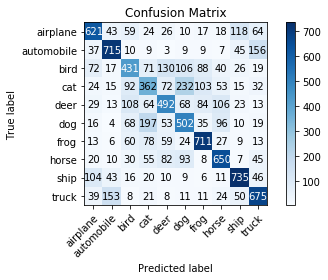

In [35]:
classLabels = np.argmax(Ctest_y, axis=1)
plot_confusion_matrix(classLabels[:],Yp, classes)

[ 0.2045347   0.0560828  -0.01277801  0.01324374  0.2487722  -0.30709104
  0.01091369 -0.38553202  0.06358758  0.46781454 -0.09628771 -0.02518744
  0.08971232  0.22194621 -0.14785373 -0.01188864  0.09779183 -0.681452
  0.28707     0.5270171  -0.18481814  0.24376576 -0.1437446   0.23382316
  0.11781995 -0.00860546  0.10033289 -0.10699288  0.00110801 -0.04189565
  0.04092537 -0.28922398]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


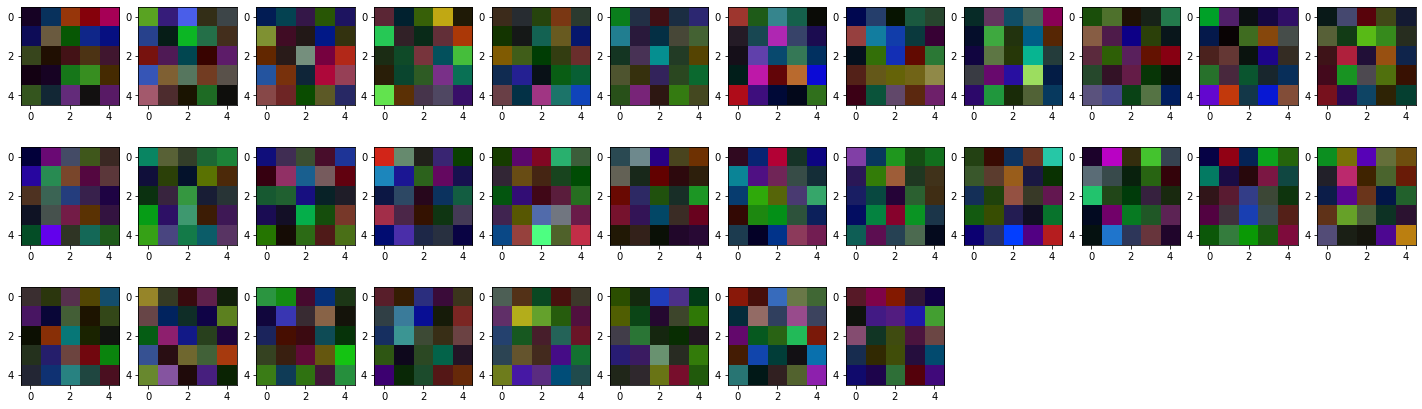

In [22]:
print(net1.ConvuPoolLayers[0].bias)
VisulaizeFilters( abs(net1.ConvuPoolLayers[0].W[:,:,:]/np.max(net1.ConvuPoolLayers[0].W)) )

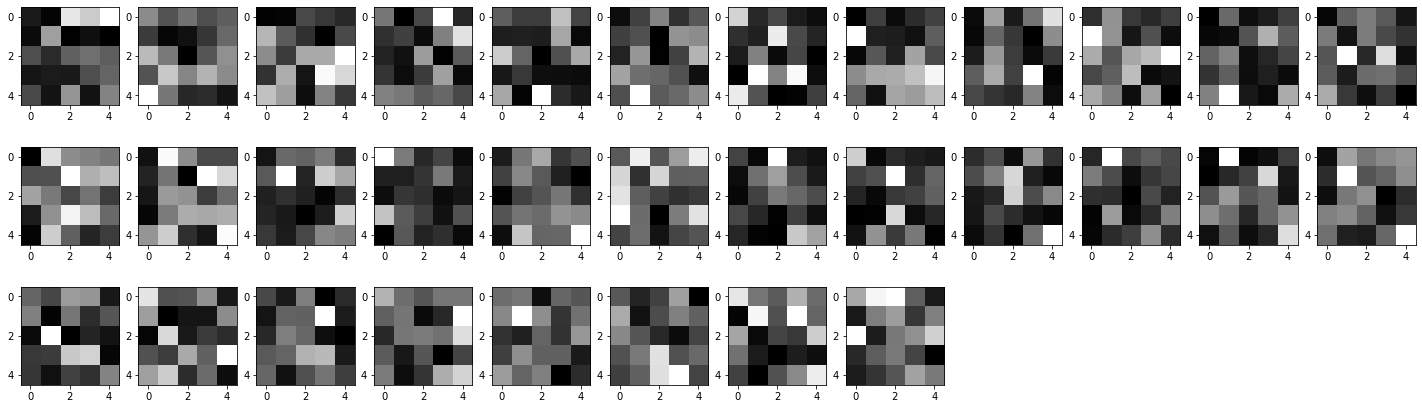

In [23]:
VisulaizeFilters( abs(net1.ConvuPoolLayers[0].W[:,:,:,0:1]/np.max(net1.ConvuPoolLayers[0].W)) )

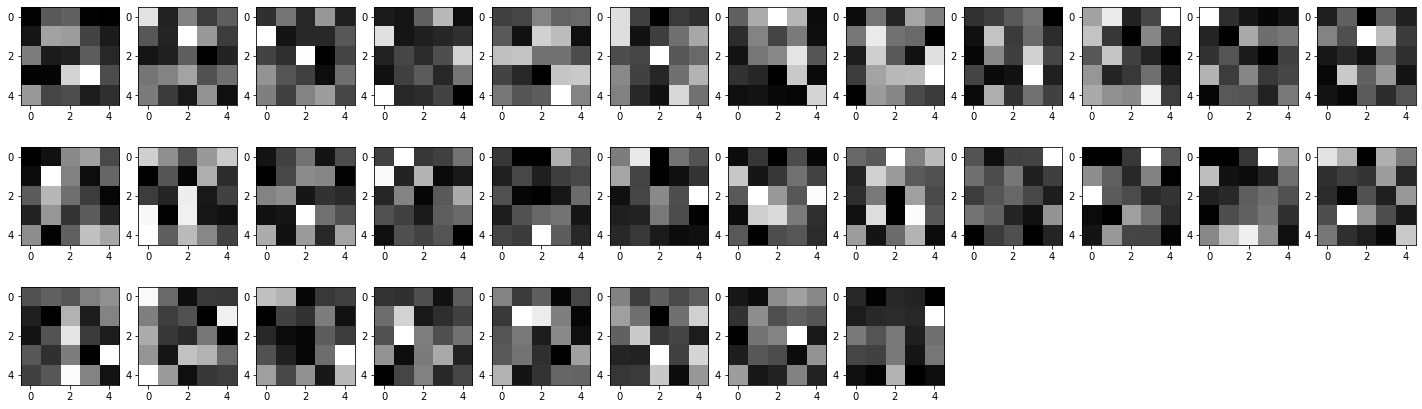

In [24]:
VisulaizeFilters( abs(net1.ConvuPoolLayers[0].W[:,:,:,1:2]/np.max(net1.ConvuPoolLayers[0].W)) )

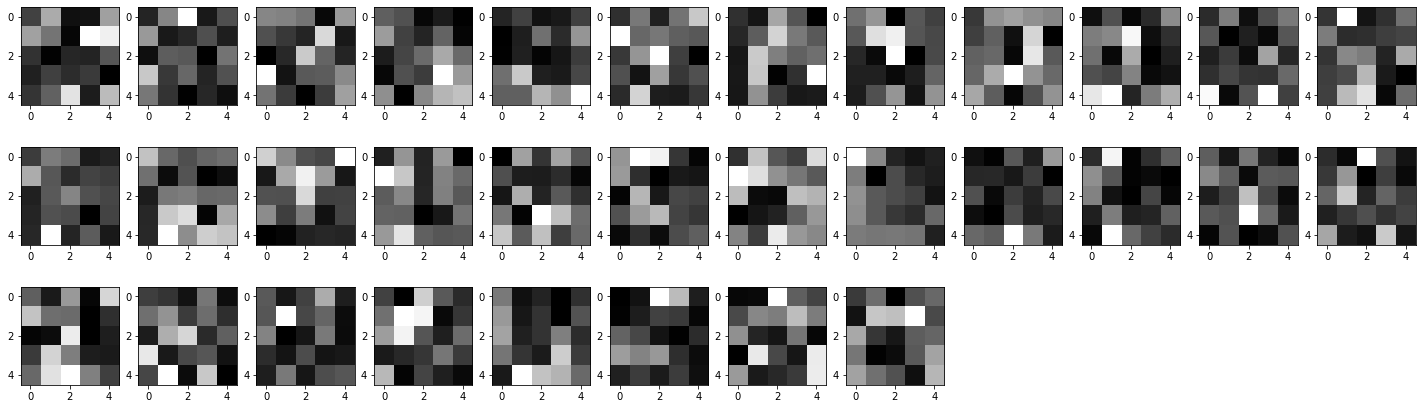

In [25]:
VisulaizeFilters( abs(net1.ConvuPoolLayers[0].W[:,:,:,2:3]/np.max(net1.ConvuPoolLayers[0].W)) )

[ 0.2045347   0.0560828  -0.01277801  0.01324374  0.2487722  -0.30709104
  0.01091369 -0.38553202  0.06358758  0.46781454 -0.09628771 -0.02518744
  0.08971232  0.22194621 -0.14785373 -0.01188864  0.09779183 -0.681452
  0.28707     0.5270171  -0.18481814  0.24376576 -0.1437446   0.23382316
  0.11781995 -0.00860546  0.10033289 -0.10699288  0.00110801 -0.04189565
  0.04092537 -0.28922398]


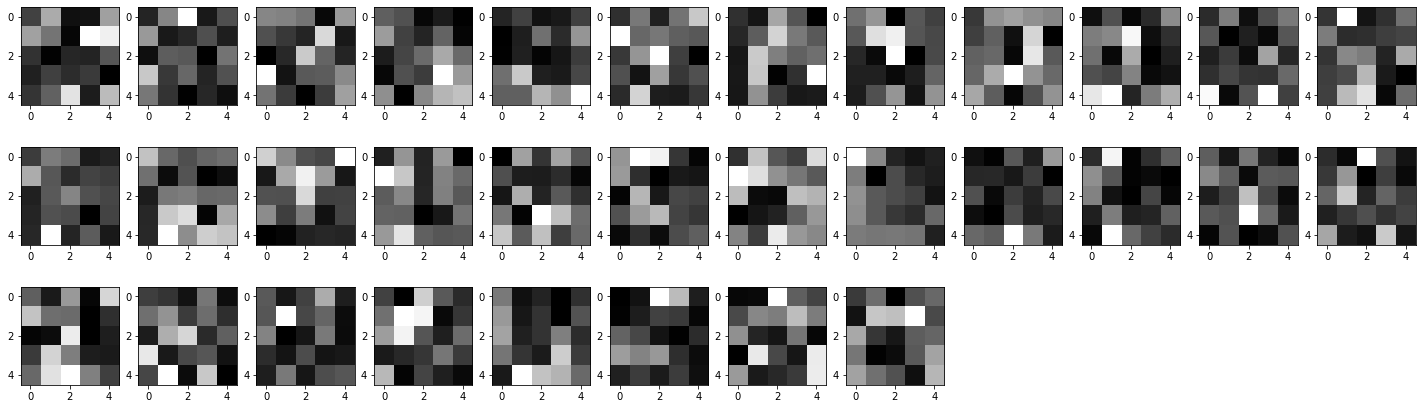

In [19]:
print(net1.ConvuPoolLayers[0].bias)
VisulaizeFilters( abs(net1.ConvuPoolLayers[0].W[:,:,:,2:3]/np.max(net1.ConvuPoolLayers[0].W)) )

In [ ]:
acc, Yp = net1.accuracy(Ctrain_x[:],Ctrain_y[:].T)
acc

In [244]:
net1.batchSz=10000